### これは畳み込みニューラルネットワークでネット上の画像が犬顔か猫顔かを判定するシステムです
### 以下に注意点を示します
・事前に，PyTorch，matplotlib，PIL，requestの各ライブラリをインストールしておく

・データセットがこのプログラムと同じディレクトリ内のフォルダに入っていることを確認する

・network.pyがこのプログラムと同じディレクトリにあることを確認する

In [1]:
# dog_cat_classifier_epoch10ver
# 必要なライブラリのインポート
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import requests

from PIL import Image
from io import BytesIO
from torchinfo import summary
from network import CNN

In [2]:
# モデル構造の可視化
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)


In [3]:
# Data preparation
# ここでAIを作る処理
# Data preparation
from network import CNN
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
                      ])

train_dataset = torchvision.datasets.ImageFolder(root='./training_set', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = torchvision.datasets.ImageFolder(root='./test_set', transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 40
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/40, Train Loss: 1.0569, Val Loss: 0.6114
Epoch 2/40, Train Loss: 0.5727, Val Loss: 0.5302
Epoch 3/40, Train Loss: 0.5262, Val Loss: 0.5244
Epoch 4/40, Train Loss: 0.4761, Val Loss: 0.6925
Epoch 5/40, Train Loss: 0.4305, Val Loss: 0.5863
Epoch 6/40, Train Loss: 0.4049, Val Loss: 0.6312
Epoch 7/40, Train Loss: 0.3518, Val Loss: 0.4625
Epoch 8/40, Train Loss: 0.3314, Val Loss: 0.4999
Epoch 9/40, Train Loss: 0.2751, Val Loss: 0.6110
Epoch 10/40, Train Loss: 0.2650, Val Loss: 0.6543
Epoch 11/40, Train Loss: 0.2149, Val Loss: 0.5932
Epoch 12/40, Train Loss: 0.1876, Val Loss: 0.6940
Epoch 13/40, Train Loss: 0.1470, Val Loss: 0.7305
Epoch 14/40, Train Loss: 0.1115, Val Loss: 0.7767
Epoch 15/40, Train Loss: 0.1042, Val Loss: 0.7458
Epoch 16/40, Train Loss: 0.0841, Val Loss: 1.1715
Epoch 17/40, Train Loss: 0.1072, Val Loss: 0.7311
Epoch 18/40, Train Loss: 0.0451, Val Loss: 0.8331
Epoch 19/40, Train Loss: 0.0383, Val Loss: 1.0610
Epoch 20/40, Train Loss: 0.0471, Val Loss: 1.0644
Epoch 21/

In [4]:
# モデルの保存
torch.save(model, 'model.pth')

### 注意： これより前の処理は一回だけで良い，もう一回実行すると大変なことになる（振り出しに戻ってしまい時間がかかる）
### モデルができたら，以下の処理を順番に実行する
・まずは，学習曲線を描画

・次に，URLから画像を取り込むための関数を作る

・関数を呼び出して，ネット上の画像を取り込んで予測

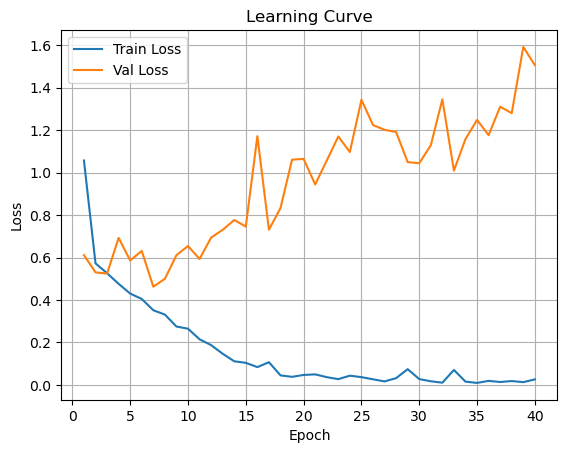

In [5]:
# Plotting learning curves
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.grid()
plt.legend()
plt.show()

In [2]:
model = torch.load("model.pth")

# URL-based prediction function
def predict_from_url(url):
    transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
    ])
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img_transformed = transform(img).unsqueeze(0)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(img_transformed)
        probability = F.softmax(output, dim=1)
        _, predicted = torch.max(output, 1)
        class_names = ['Cat', 'Dog']
        return class_names[predicted.item()], probability.tolist()[0]

In [15]:
# 判定したい画像のURLをコピペ
# url = " " のようにして" "の中にコピペする 
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSH-iBrRaJ06T05AnH_Tzijfx62m8mvBHUWEg&s"

In [16]:
predicted_class, probabilities = predict_from_url(url)
print(f"Predicted class: {predicted_class}")
print(f"Probability(Cat): {probabilities[0]}")
print(f"Probability(Dog): {probabilities[1]}")

Predicted class: Dog
Probability(Cat): 4.327554981031767e-10
Probability(Dog): 1.0
